In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import torch
import random
from torch.utils.data import DataLoader
from torch import nn, Tensor
from tempfile import TemporaryDirectory
import os
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from matplotlib.patches import FancyArrowPatch
import networkx as nx

In [2]:
sys.path.append(os.path.abspath(os.path.join('causalformer_model/')))
from model import Causalformer

In [3]:
datafolder = '../izhikevich_data/exc4_inh1_nodiag_withinp_rand/p4/inpvar5_S5_t5000/seed4/'

In [4]:
seq_len = 10
total_times = 5000
nexc = 4
ninh = 1
total_neuron = nexc+ninh
prednstep=1
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1-train_ratio-val_ratio
loss = 'mse'
enc_global_self_attn="none"
enc_local_self_attn="full"
dec_global_cross_attn="full"
dec_local_cross_attn="full"
device = torch.device("cpu")

In [5]:
d_model = 100
d_qkv = 8
n_heads = 10
ed_layers = 1
time_emb_dim = 1
dropout_emb = 0.1
dropout_ff = 0.1

Plot spike raster

In [6]:
with open(datafolder+'firings.txt') as f:
    lines = f.readlines()

spikes_mat = np.zeros((total_times, total_neuron), dtype='float32') # total time steps x total number of neurons
for l in lines:
    t, n = int(l.strip('\n').split(',')[0])-1, int(l.strip('\n').split(',')[1])-1  # matlab indices start at 1
    spikes_mat[t, n] = 1  
spikes_times = [np.nonzero(spikes_mat[:,i])[0] for i in range(total_neuron)]

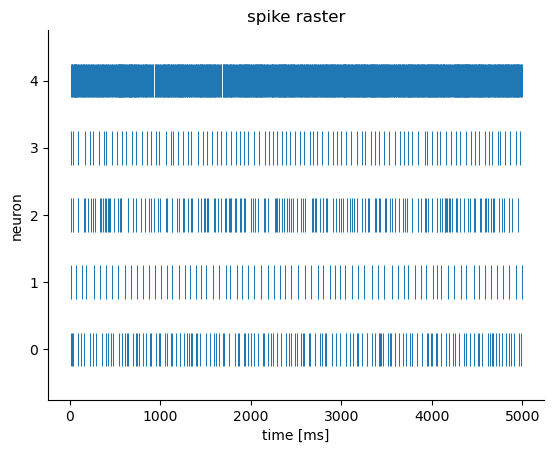

In [7]:
fig, ax = plt.subplots()
ax.eventplot(spikes_times, linewidth=0.75, linelengths=0.5)
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel('time [ms]')
plt.ylabel('neuron')
plt.title('spike raster')
plt.show()

Plot membrane potential (figure 1(b) in paper)

In [8]:
V = np.loadtxt(datafolder+'v_alltimes.txt', delimiter=',')
print(V.shape)

(5, 5001)


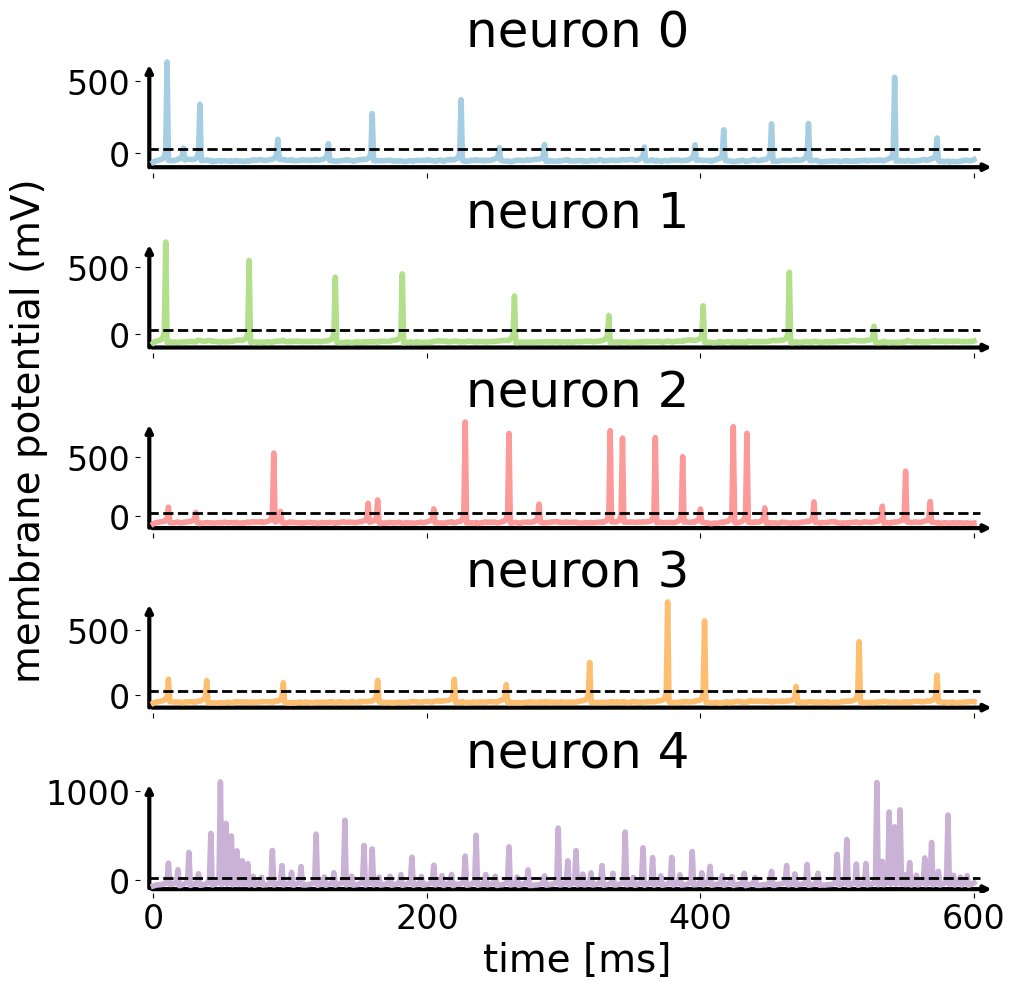

In [9]:
fig, axes = plt.subplots(total_neuron, 1, figsize=(10, total_neuron*2), sharex=True)
timerange = np.r_[0:601]
cmap = matplotlib.cm.get_cmap('Paired')
tops = []
for i in range(total_neuron):
    axes[i].plot(timerange, V[i,timerange], c=cmap(2*i), linewidth=4, alpha=1, label=f'neuron {i}')
    tops.append(np.max(V[i,timerange]))
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    axes[i].axhline(y=30, xmin=0.01, xmax=0.96, color='k', linestyle='--', linewidth=2)
    axes[i].set_ylim((-140, None))
    axes[i].set_xlim((-10, None))
    axes[i].set_title(f'neuron {i}', fontsize=36)
    axes[i].tick_params(axis='y', which='major', labelsize=24)
axes[-1].set_xticks(timerange[::200])
axes[-1].tick_params(axis='x', which='major', labelsize=24)
axes[-1].set_xlabel('time [ms]', fontsize=28)

for i, ax in enumerate(axes):
    arrow_x = FancyArrowPatch((-3, -120), (-3, tops[i]), mutation_scale=10, arrowstyle='-|>', color='k', linewidth=3)
    arrow_y = FancyArrowPatch((-3, -100), (615, -100), mutation_scale=10, arrowstyle='-|>', color='k', linewidth=3)
    ax.add_patch(arrow_x)
    ax.add_patch(arrow_y)

fig.text(-0.02, 0.32, 'membrane potential (mV)', rotation='vertical', fontsize=28)

plt.tight_layout()

plt.show()

Plot normalized membrane potential

In [10]:
V_norm = np.loadtxt(datafolder+'v_normed_alltimes.txt', delimiter=',')
print(V_norm.shape)

(5, 5001)


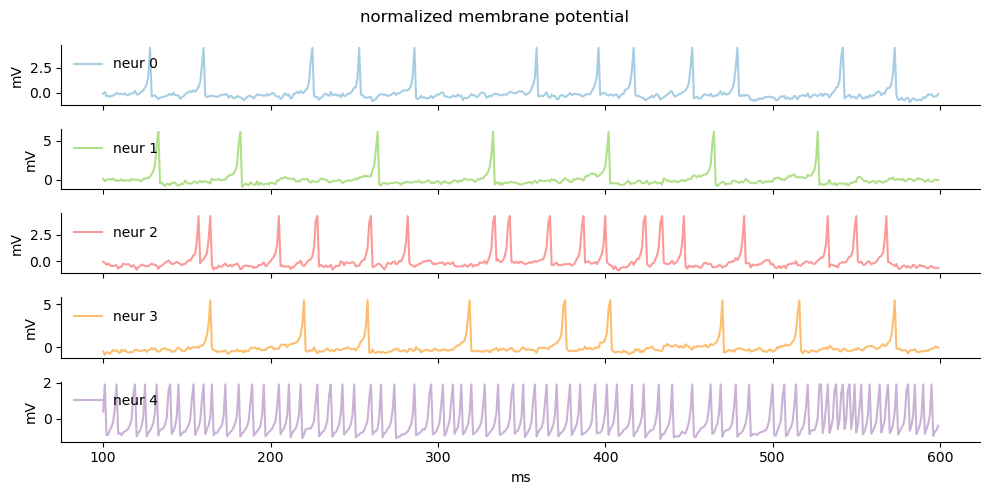

In [11]:
mpl.style.use('default')
fig, axes = plt.subplots(total_neuron, 1, figsize=(10, 5), sharex=True)
fig.suptitle('normalized membrane potential')
timerange = np.r_[100:600]
cmap = matplotlib.cm.get_cmap('Paired')
for i in range(total_neuron):
    axes[i].plot(timerange, V_norm[i,timerange], c=cmap(2*i), label='neur {}'.format(i))
    axes[i].spines[['top', 'right']].set_visible(False)
    axes[i].set_ylabel('mV')
    axes[i].legend(loc='upper left', frameon=False)
axes[-1].set_xlabel('ms')
plt.tight_layout()
plt.show()

Plot true connectivity matrix (figure 1(e) in paper)

In [12]:
with open(datafolder+'connectivity.txt') as f:
    lines = f.readlines()
    
con = np.zeros((total_neuron, total_neuron))
for k, l in enumerate(lines):
    l0 = l.strip('\n').split(',')
    l1 = [int(i) for i in l0]
    con[k] = l1

In [13]:
con_abs = np.abs(con)
con_abs = np.clip(con_abs, a_min=None, a_max=1)
print(con_abs)

[[0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]]


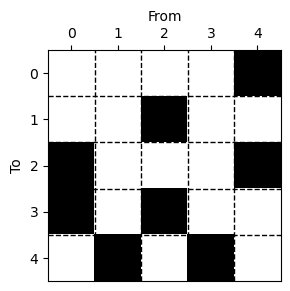

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.invert_yaxis()
ax.set_yticks([])
c = ax.pcolor(con_abs, cmap='binary')
for i in range(1, total_neuron):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)

ax.xaxis.tick_top()
ax.set_xticks(np.arange(0.5, total_neuron+0.5))
ax.set_xticklabels(np.arange(total_neuron))
ax.set_yticks(np.arange(0.5, total_neuron+0.5))
ax.set_yticklabels(np.arange(total_neuron))

ax.set_xlabel('From')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('To')
plt.show()

Plot true network (figure 1 (a) in paper)

In [16]:
con = np.clip(con, a_min=-1, a_max=1)
G = nx.DiGraph(incoming_graph_data=con.T)

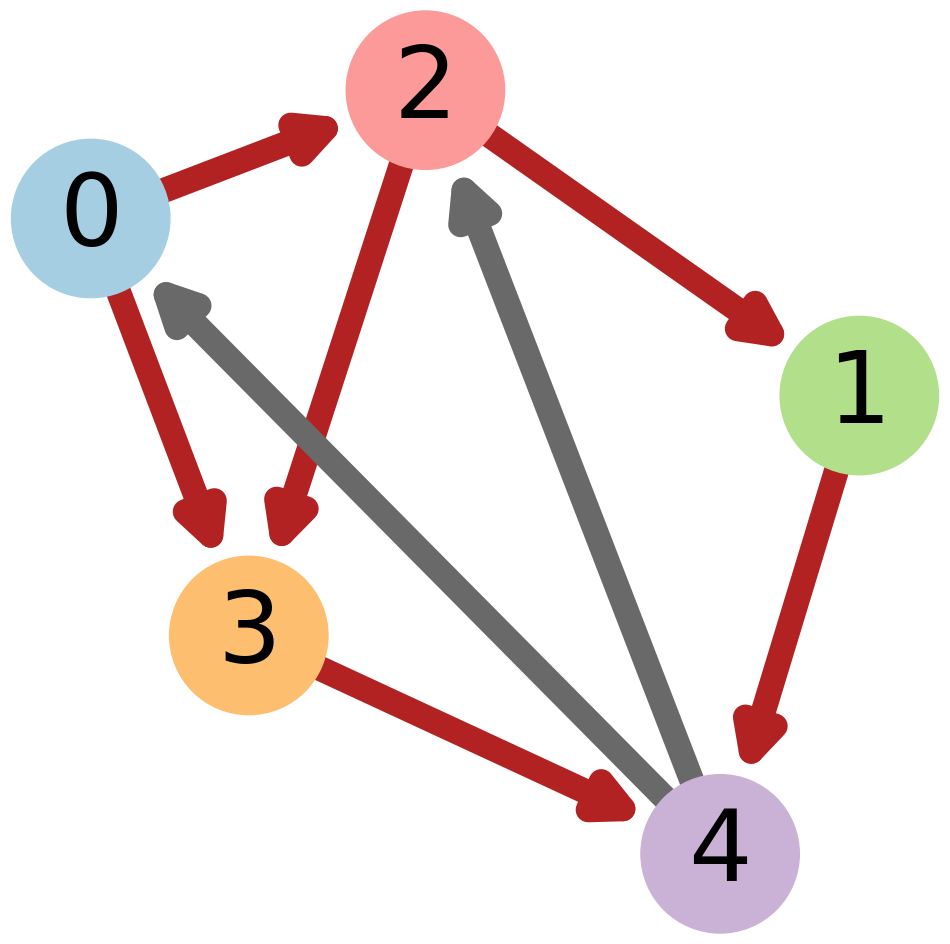

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
cmap = matplotlib.cm.get_cmap('Paired')
nx.draw_networkx(G, arrows=True, node_color=[cmap(2*i) for i in range(5)], node_size=13000, font_size=72, arrowsize=56, width=18, 
                edge_color=['firebrick', 'firebrick', 'firebrick', 'firebrick','firebrick','firebrick','dimgray','dimgray'])
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

Prepare data

In [24]:
x = np.linspace(0, total_times/1000, num=total_times, endpoint=False, dtype='float32')
y = V_norm.T
print(x.shape, y.shape)

(5000,) (5001, 5)


In [25]:
X_c = []
Y_c = []
X_t = []
Y_t = []
for i in range(len(x) - seq_len - prednstep + 1):
    X_c.append(x[i:i + seq_len])
    Y_c.append(y[i:i + seq_len, :])
    X_t.append(x[i + seq_len:i + seq_len + prednstep])
    Y_t.append(y[i + seq_len:i + seq_len + prednstep, :])

X_c = np.array(X_c)
Y_c = np.array(Y_c)
X_t = np.array(X_t)
if len(X_t.shape) == 1:
    X_t = X_t.reshape((-1, 1))
Y_t = np.array(Y_t)
if len(Y_t.shape) == 2:
    Y_t = np.expand_dims(Y_t, axis=1)
X_c = np.expand_dims(X_c, axis=-1)
X_t = np.expand_dims(X_t, axis=-1)
print(X_c.shape, Y_c.shape, X_t.shape, Y_t.shape)
total_samples = len(X_c)
print('total samples', total_samples)
X_c_train = X_c[0:int(total_samples*train_ratio)]
Y_c_train = Y_c[0:int(total_samples*train_ratio)]
X_t_train = X_t[0:int(total_samples*train_ratio)]
Y_t_train = Y_t[0:int(total_samples*train_ratio)]
X_c_val = X_c[int(total_samples*train_ratio):int(total_samples*(train_ratio+val_ratio))]
Y_c_val = Y_c[int(total_samples*train_ratio):int(total_samples*(train_ratio+val_ratio))]
X_t_val = X_t[int(total_samples*train_ratio):int(total_samples*(train_ratio+val_ratio))]
Y_t_val = Y_t[int(total_samples*train_ratio):int(total_samples*(train_ratio+val_ratio))]
X_c_test = X_c[int(total_samples*(train_ratio+val_ratio)):]
Y_c_test = Y_c[int(total_samples*(train_ratio+val_ratio)):]
X_t_test = X_t[int(total_samples*(train_ratio+val_ratio)):]
Y_t_test = Y_t[int(total_samples*(train_ratio+val_ratio)):]
print('training samples:', len(X_c_train), 'validation samples:', len(X_c_val), 'testing samples:', len(X_c_test))


(4990, 10, 1) (4990, 10, 5) (4990, 1, 1) (4990, 1, 5)
total samples 4990
training samples: 2994 validation samples: 998 testing samples: 998


In [26]:
if loss.lower() == 'poisson':
    criterion = nn.PoissonNLLLoss(log_input=False, reduction='mean')
    finalact = nn.Softplus()
elif loss.lower() == 'bce':  # binary cross entropy
    criterion = nn.BCELoss()
    finalact = nn.Sigmoid()
else:
    criterion = nn.MSELoss()
    finalact = None

In [27]:
# initialize model
CausalformerModel = Causalformer(d_yc=y.shape[-1], d_yt=y.shape[-1], d_x=1,
                                        d_model=d_model,
                                        d_queries_keys=d_qkv,
                                        d_values=d_qkv,
                                        n_heads=n_heads,
                                        e_layers=ed_layers,
                                        d_layers=ed_layers,
                                        time_emb_dim=time_emb_dim,
                                        dropout_emb=dropout_emb,
                                        dropout_ff=dropout_ff,
                                        finalact=finalact,
                                        d_ff=None, 
                                        device=device,
                                        enc_global_self_attn=enc_global_self_attn,
                                        enc_local_self_attn=enc_local_self_attn,
                                        dec_global_cross_attn=dec_global_cross_attn,
                                        dec_local_cross_attn=dec_local_cross_attn,
                                        dec_global_self_attn="none", dec_local_self_attn="none")
CausalformerModel.to(device)

Causalformer(
  (enc_embedding): SpatioTemporalEmbedding(
    (time_emb): Time2Vec()
    (local_emb): Time2Vec()
    (val_time_emb): Linear(in_features=2, out_features=100, bias=True)
    (space_emb): Embedding(5, 100)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (local_attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=100, out_features=80, bias=True)
          (key_projection): Linear(in_features=100, out_features=80, bias=True)
          (value_projection): Linear(in_features=100, out_features=80, bias=True)
          (out_projection): Linear(in_features=80, out_features=100, bias=True)
          (dropout_qkv): Dropout(p=0.0, inplace=False)
        )
        (conv1): Conv1d(100, 400, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(400, 100, kernel_size=(1,), stride=(1,))
        (norm1): Normalizati

In [28]:
CausalformerModel.load_state_dict(torch.load('example_trained_models/model_seed10.pth', map_location=device))
CausalformerModel.eval()

with torch.no_grad():
    test_outs = CausalformerModel(torch.from_numpy(X_c_test).float().to(device), 
                                  torch.from_numpy(Y_c_test).float().to(device),
                                  torch.from_numpy(X_t_test).float().to(device), 
                                  torch.from_numpy(Y_t_test).float().to(device),
                                  output_enc_attention=True, output_dec_self_attention=True, output_dec_cross_attention=True)

    test_pred, test_enc_attns, test_dec_attns = test_outs[0], test_outs[1][0], test_outs[1][1]
    print(test_pred.shape)  # batch_size, seq_len, n_var

    mse = criterion(test_pred, torch.from_numpy(Y_t_test).to(device)).item()
    r2 = r2_score(Y_t_test.reshape((-1, Y_t_test.shape[-1])), test_pred.numpy().reshape((-1, Y_t_test.shape[-1])))

    print(i, 'MSE', mse, 'r2', r2)

torch.Size([998, 1, 5])
4989 MSE 0.06242587159883655 r2 0.940553623149275


Plot model prediction (figure 4 (a) in paper)

neuron 0 r2 0.9611923573497136
neuron 1 r2 0.9253037723690946
neuron 2 r2 0.9361481576021243
neuron 3 r2 0.9483648566375059
neuron 4 r2 0.9317589717879365


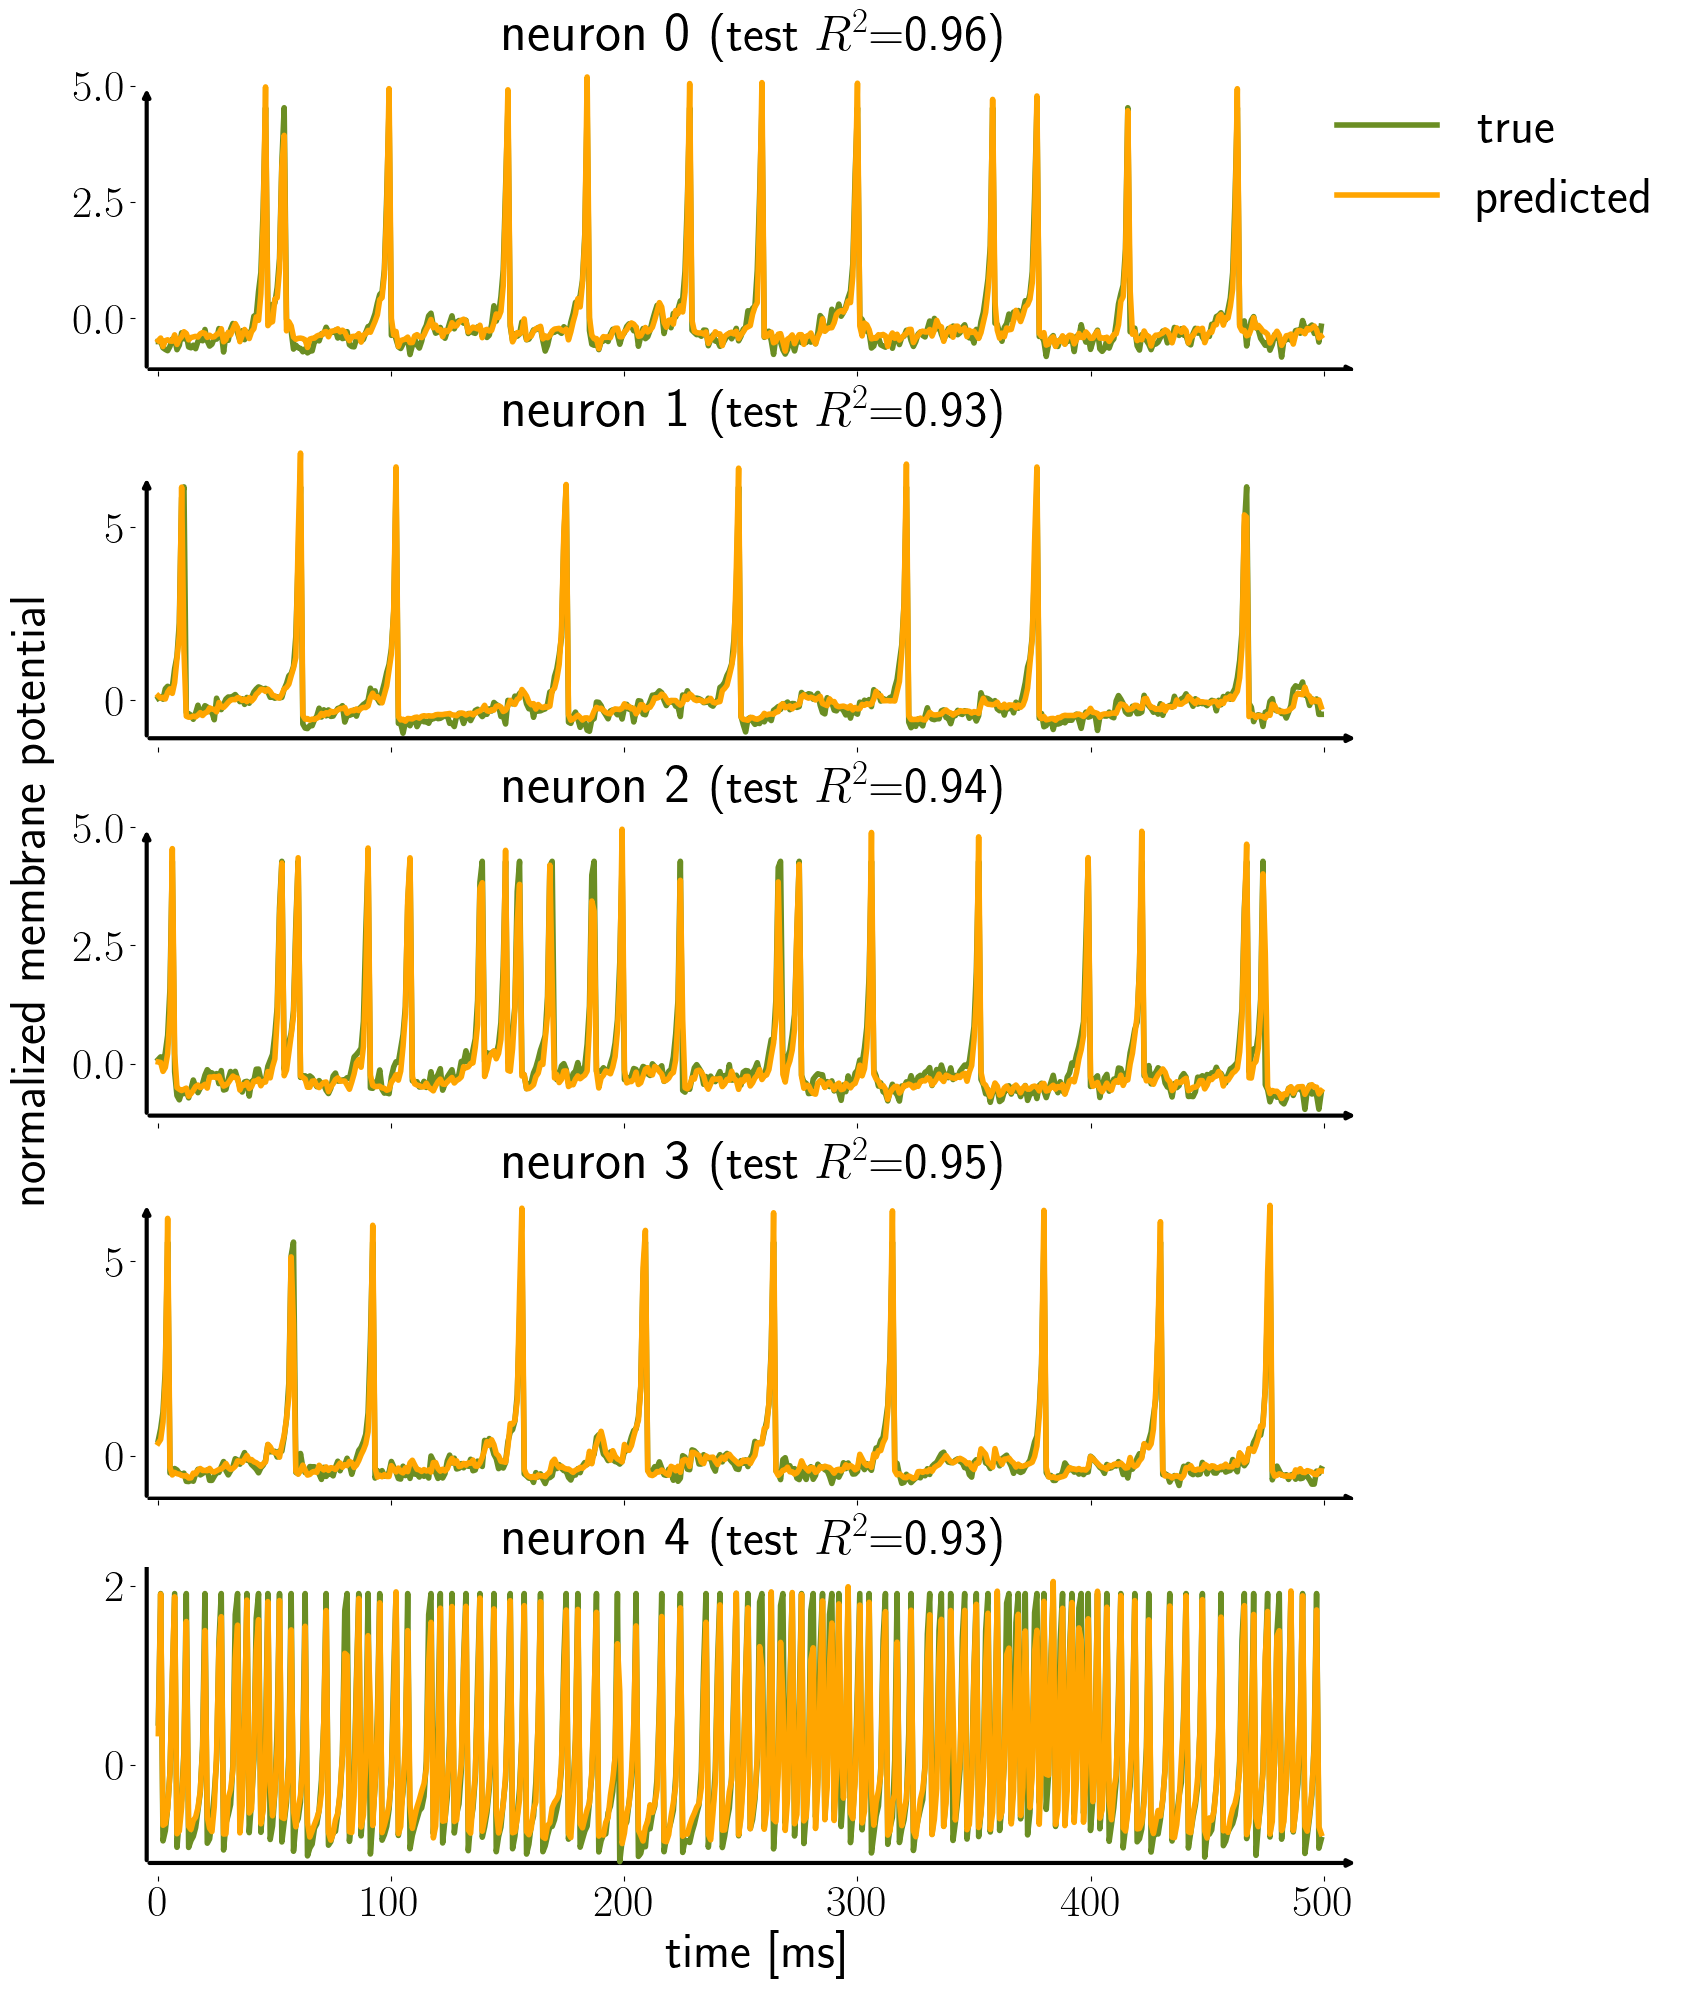

In [30]:
fig, axes = plt.subplots(y.shape[-1], 1, sharex=True, figsize=(16, 20))
plt.rc('text', usetex=True)
# fig.suptitle('Test set')
cmap = plt.get_cmap('Paired')
colors = ['olivedrab', 'orange']
T = 500
for i in range(y.shape[-1]):
    axes[i].plot(Y_t_test.squeeze(1)[:T,i], c=colors[0], linewidth=4, alpha=1, label='true')
    axes[i].plot(test_pred.squeeze(1)[:T,i], c=colors[1], linewidth=4, alpha=1, label='predicted')
    axes[i].set_xlim((-10, None))
    axes[i].spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    r = r2_score(Y_t_test.squeeze(1)[:,i], test_pred.squeeze(1)[:,i])
    print(f'neuron {i} r2', r)
    axes[i].tick_params(axis='y', which='major', labelsize=32)


axes[0].legend(bbox_to_anchor=(0.93, 1), frameon=False, fontsize=36)
axes[0].set_title(r'\fontsize{40pt}{3em}\selectfont{}{neuron 0  }{\fontsize{36pt}{3em}\selectfont{}(test $R^2$=0.96)}')
axes[1].set_title(r'\fontsize{40pt}{3em}\selectfont{}{neuron 1  }{\fontsize{36pt}{3em}\selectfont{}(test $R^2$=0.93)}')
axes[2].set_title(r'\fontsize{40pt}{3em}\selectfont{}{neuron 2  }{\fontsize{36pt}{3em}\selectfont{}(test $R^2$=0.94)}')
axes[3].set_title(r'\fontsize{40pt}{3em}\selectfont{}{neuron 3  }{\fontsize{36pt}{3em}\selectfont{}(test $R^2$=0.95)}')
axes[4].set_title(r'\fontsize{40pt}{3em}\selectfont{}{neuron 4  }{\fontsize{36pt}{3em}\selectfont{}(test $R^2$=0.93)}')
tops = [5, 6.5, 5, 6.5, 2.5]

for i, ax in enumerate(axes):
    arrow_x = FancyArrowPatch((-5, -1.1), (-5, tops[i]), mutation_scale=10, arrowstyle='-|>', color='k', linewidth=3)
    arrow_y = FancyArrowPatch((-5, -1.1), (T+15, -1.1), mutation_scale=10, arrowstyle='-|>', color='k', linewidth=3)
    ax.add_patch(arrow_x)
    ax.add_patch(arrow_y)

axes[-1].tick_params(axis='x', which='major', labelsize=32)
axes[-1].set_xlabel('time [ms]', fontsize=36)
fig.text(-0.05, 0.4, 'normalized membrane potential', rotation='vertical', fontsize=36)

plt.tight_layout()
plt.show()

Load models across 10 different initializations (random seeds)

In [31]:
seeds = np.arange(10, 20)
resfolder = 'example_trained_models/'

In [32]:
dec_cross_attn_allruns = []
val_mse_allruns = []
test_mse_allruns = []
test_r2_allruns = []
test_pred_allruns = []
for se in seeds:
    CausalformerModel.load_state_dict(torch.load(resfolder+f'model_seed{se}.pth', map_location=device))
    CausalformerModel.eval()
    enc_self_attn_onerun = []
    dec_cross_attn_onerun = []
    # get val res
    with open(resfolder+f'seed{se}_prog.txt'.format(k)) as f1:
        lines = f1.readlines()
    val_res = float(lines[-1].split()[-1])
    if lines[-2].split()[0] == 'early':
        act_epoch = int(lines[-2].split()[-1])
    else:
        act_epoch = maxepoch
        
    with torch.no_grad():
        test_outs = CausalformerModel(torch.from_numpy(X_c_test).float().to(device), 
                                      torch.from_numpy(Y_c_test).float().to(device),
                                      torch.from_numpy(X_t_test).float().to(device), 
                                      torch.from_numpy(Y_t_test).float().to(device), 
                                      output_enc_attention=True, 
                                      output_dec_self_attention=True, 
                                      output_dec_cross_attention=True)
        
        test_pred, test_enc_attns, test_dec_attns = test_outs[0], test_outs[1][0], test_outs[1][1]

        mse = criterion(test_pred, torch.from_numpy(Y_t_test).to(device)).item()
        r2 = r2_score(Y_t_test.reshape((-1, Y_t_test.shape[-1])), test_pred.numpy().reshape((-1, Y_t_test.shape[-1])))
        val_mse_allruns.append(val_res)
        test_mse_allruns.append(mse)
        test_r2_allruns.append(r2)
        print('seed', se, 'test MSE', mse, 'test r2', r2, 'val MSE', val_res, 'trained epoch', act_epoch)
        
    # collect all decoder global cross attentions
    dec_cross_attn_onerun = np.stack([test_dec_attns[l][3].cpu().numpy() for l in range(ed_layers)], axis=0)
#     print(dec_cross_attn_onerun.shape)  # n_layers, n_samples, n_heads, len_out, len_in
    dec_cross_attn_allruns.append(dec_cross_attn_onerun)
    test_pred_allruns.append(test_pred)      

seed 10 test MSE 0.06242587159883655 test r2 0.940553623149275 val MSE 0.056014249249110144 trained epoch 31
seed 11 test MSE 0.07340809639862163 test r2 0.9303631161601776 val MSE 0.053986089392786936 trained epoch 32
seed 12 test MSE 0.0678418633288624 test r2 0.9355495511124472 val MSE 0.05589546952100973 trained epoch 38
seed 13 test MSE 0.07303855785950367 test r2 0.9305003862274832 val MSE 0.06488295011813679 trained epoch 22
seed 14 test MSE 0.06229069983836047 test r2 0.9407547970121766 val MSE 0.056176401379089504 trained epoch 41
seed 15 test MSE 0.06541451146132811 test r2 0.9378113946057967 val MSE 0.05673849340232592 trained epoch 35
seed 16 test MSE 0.04756637202179956 test r2 0.9546788110809942 val MSE 0.05182983442431405 trained epoch 48
seed 17 test MSE 0.09768975172777498 test r2 0.9076437455946765 val MSE 0.05236855193617798 trained epoch 48
seed 18 test MSE 0.05182595609496203 test r2 0.9506712966323982 val MSE 0.05404857158779152 trained epoch 34
seed 19 test MSE 0

In [33]:
# take the average decoder cross attention across seeds
dec_attn_sum_seq_alllayer_sampavg_allseeds = []
for k in range(len(seeds)):
#     dec_cross_attn_onerun = np.load(resfolder+f+'testDecGlobalAttn.npy')
    dec_cross_attn_onerun = dec_cross_attn_allruns[k]
    attn_allh = np.sum(dec_cross_attn_onerun, axis=2) # sum all heads
    attn_sum_seq = np.zeros((dec_cross_attn_onerun.shape[0], dec_cross_attn_onerun.shape[1], y.shape[-1], y.shape[-1]))  # sum over sequence
    for i in range(y.shape[-1]):
        for j in range(y.shape[-1]):
            attn_sum_seq[:, :, i, j] = np.apply_over_axes(np.sum, attn_allh[:, :, int(i*prednstep):int(i*prednstep+prednstep), int(j*seq_len):int(j*seq_len+seq_len)], [2,3]).squeeze()

    attn_sum_seq_alllayer = np.sum(attn_sum_seq, axis=0)  # sum over layers
    attn_sum_seq_alllayer_sampavg = np.mean(attn_sum_seq_alllayer, axis=0) # average across samples
    dec_attn_sum_seq_alllayer_sampavg_allseeds.append(attn_sum_seq_alllayer_sampavg)
    
dec_attn_sum_seq_alllayer_sampavg_allseeds = np.stack(dec_attn_sum_seq_alllayer_sampavg_allseeds, axis=0)
print(dec_attn_sum_seq_alllayer_sampavg_allseeds.shape)

(10, 5, 5)


In [34]:
# renormalize the attention matrices so each row sum up to 1
dec_attn_sum_seq_alllayer_sampavg_allseeds_norm = []
for i in range(dec_attn_sum_seq_alllayer_sampavg_allseeds.shape[0]):
    a = dec_attn_sum_seq_alllayer_sampavg_allseeds[i]
    dec_attn_sum_seq_alllayer_sampavg_allseeds_norm.append((a.T/a.sum(axis=1)).T)
dec_attn_sum_seq_alllayer_sampavg_allseeds_norm = np.stack(dec_attn_sum_seq_alllayer_sampavg_allseeds_norm, axis=0)
print(dec_attn_sum_seq_alllayer_sampavg_allseeds_norm.shape)

(10, 5, 5)


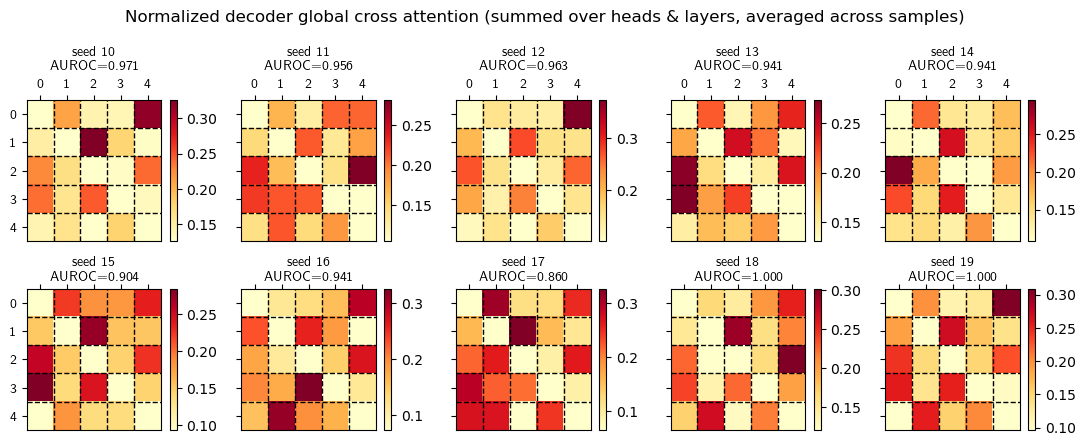

In [35]:
# plot all seeds together
fig, axes = plt.subplots(2, 5, sharey='row', figsize=(11, 4.5))
plt.rc('text', usetex=False)
fig.suptitle('Normalized decoder global cross attention (summed over heads & layers, averaged across samples)')
for s in range(len(seeds)):
    row = s // 5
    col = s%5
    ax = axes[row, col]
    ax.invert_yaxis()
    ax.set_yticks([])
    ax.xaxis.tick_top()
    toplot=dec_attn_sum_seq_alllayer_sampavg_allseeds_norm[s, :, :]
    toplot_ = toplot - np.diag(np.diag(toplot))
    vmin = np.min(toplot_[toplot_>0])
    
    c = ax.pcolor(toplot_, vmin=vmin, cmap='YlOrRd')
    for i in range(1, y.shape[-1]):
        ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
        ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
    cbar = fig.colorbar(c, ax=ax)
    ax.set_xticks(np.arange(0.5, y.shape[-1]+0.5))
    labels = ['0', '1', '2', '3', '4']
    ax.set_yticks(np.arange(0.5, y.shape[-1]+0.5))
    if row == 0:
        ax.set_xticklabels(labels)
    else:
        ax.set_xticklabels([])
    if col == 0:
        ax.set_yticklabels(labels)
    
    auroc = roc_auc_score(con_abs.flatten(), toplot_.flatten())
    ax.set_title('seed {} \n AUROC={:.3f}'.format(seeds[s],auroc), fontsize=10)

plt.tight_layout()
plt.show()

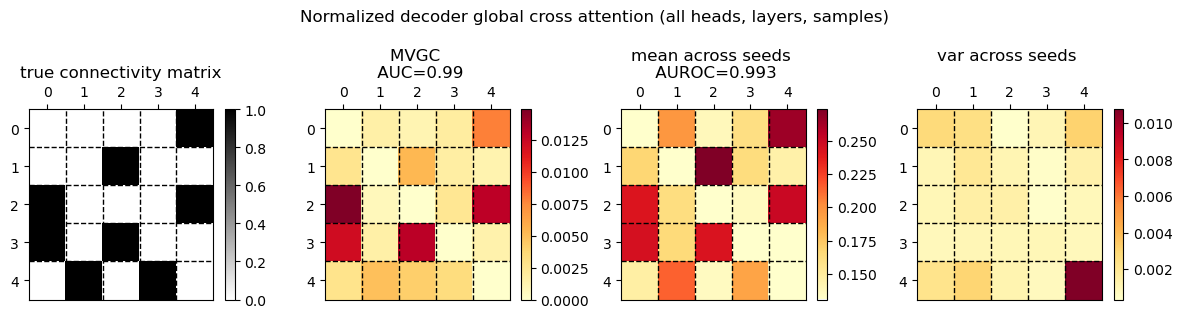

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3.2))
fig.suptitle('Normalized decoder global cross attention (all heads, layers, samples)')
ax = axes[0]
ax.invert_yaxis()
ax.set_yticks([])
c = ax.pcolor(con_abs, cmap='binary')
for i in range(1, total_neuron):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
cbar = fig.colorbar(c, ax=ax)
ax.xaxis.tick_top()
ax.set_xticks(np.arange(0.5, total_neuron+0.5))
ax.set_xticklabels(np.arange(total_neuron))
ax.set_yticks(np.arange(0.5, total_neuron+0.5))
ax.set_yticklabels(np.arange(total_neuron))
ax.set_title('true connectivity matrix')

ax = axes[1]
mvgc_sig = np.loadtxt(datafolder+'mvgc_aic_F_p10.txt', delimiter=',')
mvgc_sig = np.nan_to_num(mvgc_sig, nan=0)
ax.invert_yaxis()
ax.set_yticks([])
ax.xaxis.tick_top()
c = ax.pcolor(mvgc_sig, cmap='YlOrRd')
for i in range(1, 5):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
cbar = fig.colorbar(c, ax=ax)
ax.set_xticks(np.arange(0.5, 5+0.5))
labels = ['0', '1', '2', '3', '4']
ax.set_yticks(np.arange(0.5, 5+0.5))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
auroc = roc_auc_score(con_abs.flatten(), mvgc_sig.flatten())
ax.set_title('MVGC \n AUC={:.2f}'.format(auroc))


ax = axes[2]
ax.invert_yaxis()
ax.set_yticks([])
ax.xaxis.tick_top()
toplot=np.mean(dec_attn_sum_seq_alllayer_sampavg_allseeds_norm, axis=0)
toplot_ = toplot - np.diag(np.diag(toplot))
vmin = np.min(toplot_[toplot_>0])
c = ax.pcolor(toplot_, vmin=vmin, cmap='YlOrRd') # average across seeds
for i in range(1, y.shape[-1]):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
cbar = fig.colorbar(c, ax=ax)
ax.set_xticks(np.arange(0.5, y.shape[-1]+0.5))
labels = ['0', '1', '2', '3', '4']
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(0.5, y.shape[-1]+0.5))
ax.set_yticklabels(labels)
auroc = roc_auc_score(con_abs.flatten(), toplot_.flatten())
ax.set_title('mean across seeds \n AUROC={:.3f}'.format(auroc))  # (figure 1 (d) in paper)

ax = axes[3]
ax.invert_yaxis()
ax.set_yticks([])
ax.xaxis.tick_top()
c = ax.pcolor(np.var(dec_attn_sum_seq_alllayer_sampavg_allseeds_norm, axis=0), cmap='YlOrRd') # average across seeds
for i in range(1, y.shape[-1]):
    ax.axhline(y=i, color='k', linestyle='--', linewidth=1)
    ax.axvline(x=i, color='k', linestyle='--', linewidth=1)
cbar = fig.colorbar(c, ax=ax)
ax.set_xticks(np.arange(0.5, y.shape[-1]+0.5))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(0.5, y.shape[-1]+0.5))
ax.set_yticklabels(labels)
ax.set_title('var across seeds \n')


plt.tight_layout()
plt.show()